[*********************100%***********************]  1 of 1 completed


-------------------------------Display Columns inside the dataset--------------------------
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Price_Change',
       'Category'],
      dtype='object')
-------------------------------Head of the dataset:----------------------------------------
             Adj Close       Close        High         Low        Open  \
Date                                                                     
2015-01-02  503.038666  506.368683  511.909271  491.973083  491.973083   
2015-01-05  514.833313  518.241333  520.417969  501.322815  504.686737   
2015-01-06  492.816742  496.079071  508.891632  493.951874  508.891632   
2015-01-07  485.395966  488.609192  495.089661  484.008514  489.746979   
2015-01-08  503.235260  506.566559  509.336853  495.683289  498.651459   

             Volume  Price_Change  Category  
Date                                         
2015-01-02  4193093     13.208313         1  
2015-01-05  6758676     11.872650      

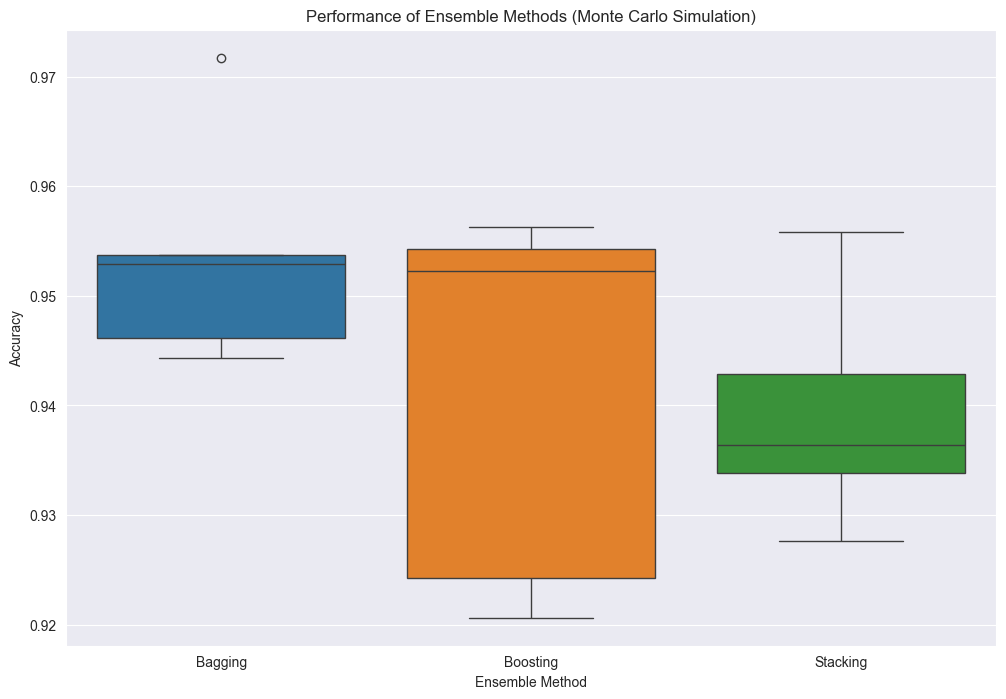

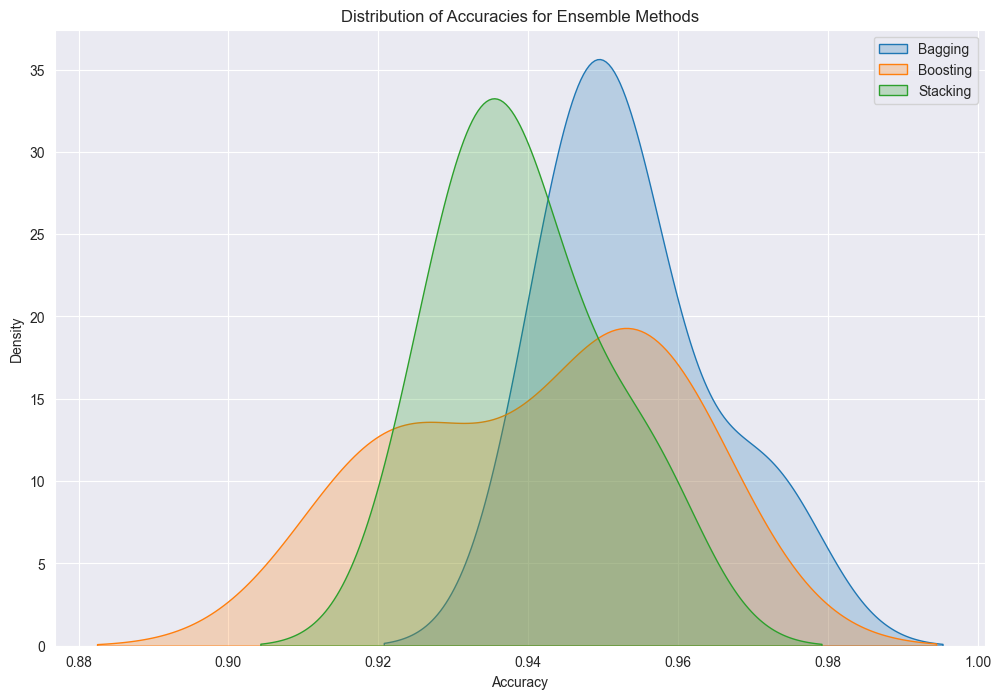


===================== Ensemble Methods Summary Statistics =====================

          Mean Accuracy  Median Accuracy   Std Dev  Min Accuracy  Max Accuracy
Bagging        0.953768         0.952941  0.009703      0.944334      0.971731
Boosting       0.941550         0.952297  0.015697      0.920635      0.956303
Stacking       0.939308         0.936382  0.009599      0.927609      0.955830
Bagging - Mean Accuracy: 0.9538, Std Dev: 0.0097
Boosting - Mean Accuracy: 0.9416, Std Dev: 0.0157
Stacking - Mean Accuracy: 0.9393, Std Dev: 0.0096

-----------------------------------------------------------------------------Regression Steps Commence----------------------------------------------------------------------------------

Regression Results without PCA:
RandomForestRegressor - MSE: 0.3632, R2: 1.0000
GradientBoostingRegressor - MSE: 1.3778, R2: 0.9999
AdaBoostRegressor - MSE: 73.4140, R2: 0.9961
XGBRegressor - MSE: 2.4969, R2: 0.9999

Number of PCA components chosen to retain at leas

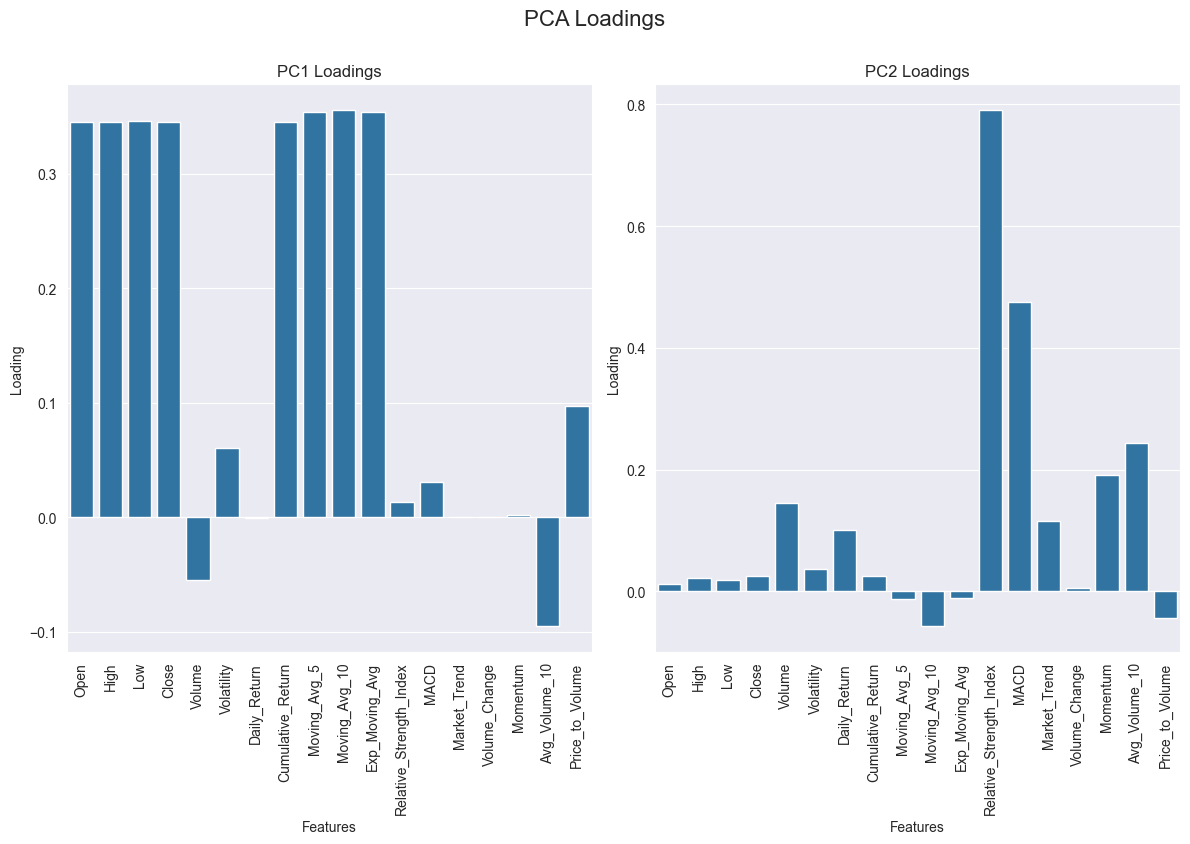


Regression Results with PCA:
RandomForestRegressor(PCA) - MSE: 32.8742, R2: 0.9982


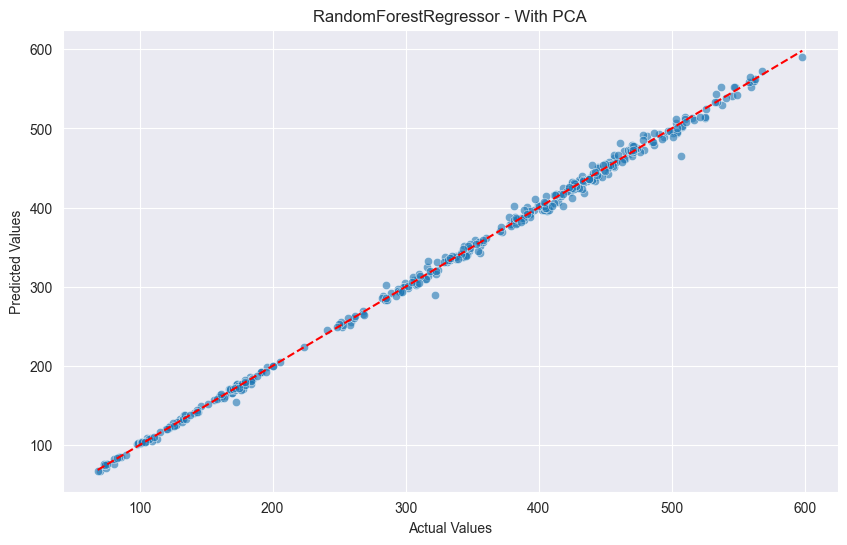

GradientBoostingRegressor(PCA) - MSE: 25.3361, R2: 0.9986


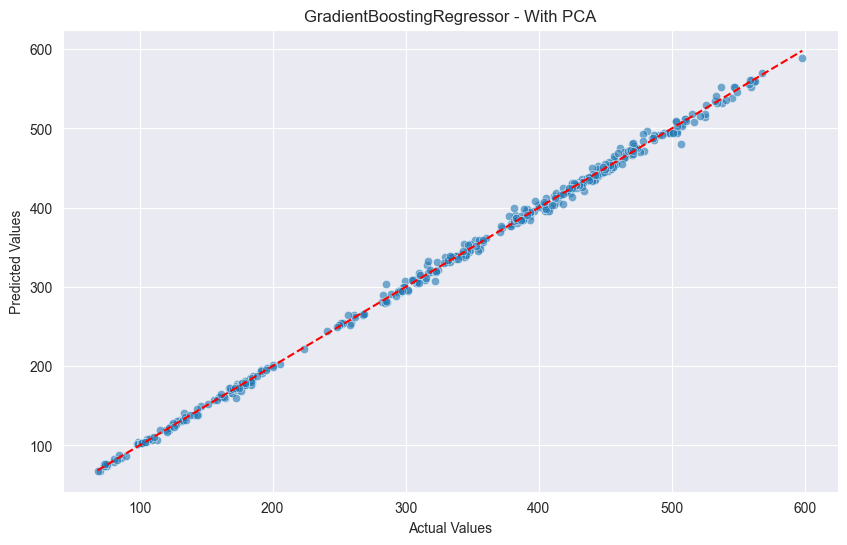

AdaBoostRegressor(PCA) - MSE: 71.0484, R2: 0.9962


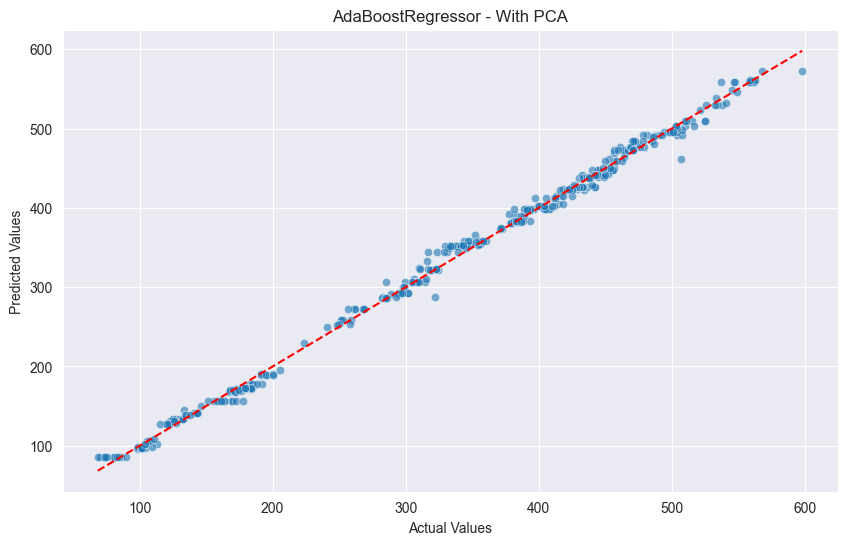

XGBRegressor(PCA) - MSE: 31.0188, R2: 0.9983


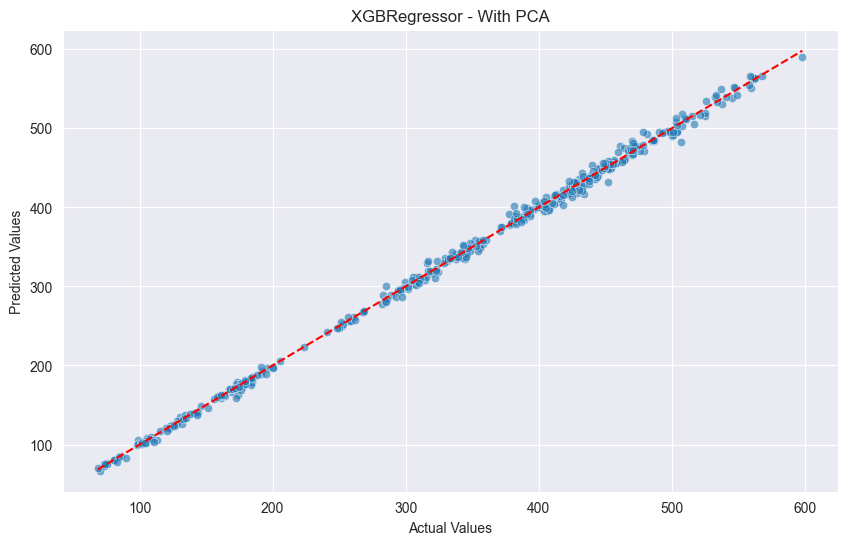

In [1]:
# Import statements
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import mplfinance as mpf
import warnings

from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')


class Visualization:
    @staticmethod
    def plot_boxplot(results, title, ylabel, xlabel):
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=pd.DataFrame(results))
        #sns.swarmplot(data=pd.DataFrame(results), color=".25")
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.show()

    @staticmethod
    def plot_regression_results(y_true, y_pred, title):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.title(title)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.show()

    @staticmethod
    def plot_residuals(y_true, y_pred, title):
        residuals = y_true - y_pred
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.title(title)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.show()

    @staticmethod
    def plot_feature_importance(model, feature_names, title):
        pass

    @staticmethod
    def plot_pca_explained_variance(pca, title="PCA Explained Variance"):
        pass

    @staticmethod
    def plot_pca_loadings(pca, feature_names, n_components=2, title="PCA Loadings"):
        plt.figure(figsize=(12, 8))
        components = pca.components_[:n_components]
        for i in range(n_components):
            plt.subplot(1, n_components, i + 1)
            sns.barplot(x=feature_names, y=components[i])
            plt.title(f'PC{i+1} Loadings')
            plt.xlabel('Features')
            plt.ylabel('Loading')
            plt.xticks(rotation=90)
            plt.tight_layout()
        plt.suptitle(title, fontsize=16, y=1.05)
        plt.show()

    @staticmethod
    def plot_correlation_heatmap(data, title="Feature Correlation Heatmap"):
        pass

    @staticmethod
    def plot_confusion_matrix_heatmap(conf_matrix, classes, title="Confusion Matrix"):
        pass

    @staticmethod
    def plot_roc_curve(model, X_test, y_test, title="ROC Curve"):
        pass

    @staticmethod
    def plot_precision_recall_curve(model, X_test, y_test, title="Precision-Recall Curve"):
        pass

    @staticmethod
    def plot_time_series(y_true, y_pred, dates, title="Actual vs Predicted Close Prices"):
        plt.figure(figsize=(14, 7))
        plt.plot(dates, y_true, label='Actual Close Prices', color='blue')
        plt.plot(dates, y_pred, label='Predicted Close Prices', color='orange', alpha=0.7)
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title(title)
        plt.legend()
        plt.show()


class StockPricePredictor:
    def __init__(self, stock_symbol, start_date, end_date):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.features = [
            'Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'Daily_Return', 'Cumulative_Return',
            'Moving_Avg_5', 'Moving_Avg_10', 'Exp_Moving_Avg', 'Relative_Strength_Index', 'MACD', 'Market_Trend',
            'Volume_Change', 'Momentum', 'Avg_Volume_10', 'Price_to_Volume'
        ]
        # Classification variables
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_balanced = None
        self.y_train_balanced = None

    def fetch_data(self):
        data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)

        # Flatten the multi-index columns if present
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data.columns.values]

        # Simplify column names by removing the ticker suffix
        ticker_suffix = f"_{self.stock_symbol}"
        rename_dict = {col: col.replace(ticker_suffix, "") for col in data.columns if ticker_suffix in col}
        data.rename(columns=rename_dict, inplace=True)

        # Create classification target
        data['Price_Change'] = data['Close'].diff()
        data['Category'] = (data['Price_Change'] > 0).astype(int)

        # Drop NaN values
        self.data = data.dropna()

        # Display data exploration information
        print("-------------------------------Display Columns inside the dataset--------------------------")
        print(self.data.columns)
        print("-------------------------------Head of the dataset:----------------------------------------")
        print(self.data.head())
        print("-------------------------------Tail of the dataset:----------------------------------------")
        print(self.data.tail())
        print("-------------------------------Dataset Information:----------------------------------------")
        print(self.data.info())
        print("-------------------------------Descriptive Statistics:-------------------------------------")
        print(self.data.describe())
        print("-------------------------------Dataset Shape:----------------------------------------------")
        print(self.data.shape)
        print("-------------------------------Missing Values:---------------------------------------------")
        print(self.data.isnull().sum())
        print("-------------------------------------------------------------------------------------------")

    def feature_engineering(self):
        """
        Creates additional features to enrich the dataset.
        """
        self.data['Volatility'] = self.data['High'] - self.data['Low']
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Cumulative_Return'] = (1 + self.data['Daily_Return']).cumprod()
        self.data['Moving_Avg_5'] = self.data['Close'].rolling(window=5).mean()
        self.data['Moving_Avg_10'] = self.data['Close'].rolling(window=10).mean()
        self.data['Exp_Moving_Avg'] = self.data['Close'].ewm(span=5, adjust=False).mean()
        self.data['Relative_Strength_Index'] = self.calculate_rsi(self.data['Close'], window=14)
        self.data['MACD'] = self.calculate_macd(self.data['Close'])
        self.data['Market_Trend'] = self.data['Close'] / self.data['Open'] - 1
        self.data['Volume_Change'] = self.data['Volume'].pct_change()
        self.data['Momentum'] = self.data['Close'] - self.data['Close'].shift(4)
        self.data['Avg_Volume_10'] = self.data['Volume'].rolling(window=10).mean()
        self.data['Price_to_Volume'] = self.data['Close'] / self.data['Volume']
        self.data = self.data.dropna()

    def calculate_rsi(self, prices, window):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices):
        ema_12 = prices.ewm(span=12, adjust=False).mean()
        ema_26 = prices.ewm(span=26, adjust=False).mean()
        return ema_12 - ema_26

    def detect_and_remove_outliers(self, X, threshold=3):
        # Convert to DataFrame for easier manipulation
        X_df = pd.DataFrame(X, columns=self.features)
        z_scores = np.abs((X_df - X_df.mean()) / X_df.std(ddof=1))
        mask = (z_scores < threshold).all(axis=1)
        return X[mask], mask

    def prepare_data(self, test_size=0.2, random_state=None):
        X = self.data[self.features].values  # Convert to NumPy array
        y = self.data['Category'].values

        # Split data into training and testing sets with variability in random_state
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Detect and remove outliers from the training set
        X_train_no_outliers, mask = self.detect_and_remove_outliers(self.X_train, threshold=3)
        y_train_no_outliers = self.y_train[mask]

        # Scale the features using MinMaxScaler
        scaler = MinMaxScaler()
        X_train_no_outliers = scaler.fit_transform(X_train_no_outliers)
        X_test_scaled = scaler.transform(self.X_test)

        # Handle class imbalance with SMOTE
        smote = SMOTE(random_state=random_state)
        self.X_train_balanced, self.y_train_balanced = smote.fit_resample(X_train_no_outliers, y_train_no_outliers)

        self.X_test = X_test_scaled

    def train_and_evaluate_models(self):
        # Initialize classifiers without fixed random_state for variability
        models = {
            "Support Vector Machine": SVC(probability=True),
            "Logistic Regression": LogisticRegression(),
            "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
        }
        results = []

        for model_name, model in models.items():
            model.fit(self.X_train_balanced, self.y_train_balanced)
            predictions = model.predict(self.X_test)

            # Collect evaluation metrics
            accuracy = accuracy_score(self.y_test, predictions)
            class_report = classification_report(self.y_test, predictions, output_dict=True)
            conf_matrix = confusion_matrix(self.y_test, predictions)

            # Print metrics
            print(f"-------------------------------- {model_name} ----------------------------------")
            print(f"Accuracy: {accuracy:.4f}")
            print("Classification Report:")
            print(pd.DataFrame(class_report).transpose())
            print("Confusion Matrix:")
            print(conf_matrix)
            print("\n")

            # Append results for summary
            results.append({
                "Model": model_name,
                "Accuracy": accuracy,
                "Confusion Matrix": conf_matrix,
                "Classification Report": class_report
            })

        return results

    def train_and_evaluate_with_splits(self, test_sizes):
        overall_results = []

        for test_size in test_sizes:
            print(f"===================== Evaluating with Test Size: {test_size} =====================")
            # Introduce variability by using a random random_state
            rand_state = np.random.randint(0, 10000)
            self.prepare_data(test_size=test_size, random_state=rand_state)
            split_results = self.train_and_evaluate_models()
            for result in split_results:
                result["Test Size"] = test_size
                overall_results.append(result)

        # Create a tabular summary
        results_summary = [
            {
                "Model": result["Model"],
                "Test Size": result["Test Size"],
                "Accuracy": result["Accuracy"]
            }
            for result in overall_results
        ]

        # Convert to a DataFrame
        results_df = pd.DataFrame(results_summary)

        # Sort results by Model for grouping
        results_df = results_df.sort_values(by="Model").reset_index(drop=True)

        print("\n===================== Tabular Evaluation Results =====================\n")
        print(results_df)

        return results_df

    def evaluate_ensemble_methods(self, monte_carlo_runs=5):
        # Define ensemble methods without fixed random_state
        ensemble_methods = {
            "Bagging": BaggingClassifier(estimator=SVC(probability=True)),
            "Boosting": AdaBoostClassifier(estimator=LogisticRegression()),
            "Stacking": StackingClassifier(
                estimators=[
                    ('svc', SVC(probability=True)),
                    ('logreg', LogisticRegression()),
                    ('knn', KNeighborsClassifier(n_neighbors=5))
                ],
                final_estimator=GradientBoostingClassifier(),
                passthrough=False
            )
        }

        # Define hyperparameter grids for each ensemble method
        hyperparameter_grids = {
            "Bagging": {
                "n_estimators": [10, 20, 50, 100],
                "max_samples": [0.5, 0.7, 1.0],
                "max_features": [0.5, 0.7, 1.0]
            },
            "Boosting": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 0.5, 1.0]
            },
            "Stacking": {
                "final_estimator__learning_rate": [0.01, 0.1, 0.5],
                "final_estimator__n_estimators": [50, 100, 150]
            }
        }

        # Initialize results and all_accuracies dictionaries
        results = {method: [] for method in ensemble_methods.keys()}
        all_accuracies = {method: [] for method in ensemble_methods.keys()}  # Properly defined

        for run in range(monte_carlo_runs):
            test_size = np.random.uniform(0.2, 0.4)
            rand_state = np.random.randint(0, 100000)
            self.prepare_data(test_size=test_size, random_state=rand_state)
            print(f"Monte Carlo Run: {run + 1}/{monte_carlo_runs}")

            for method_name, model in ensemble_methods.items():
                param_grid = hyperparameter_grids.get(method_name, {})
                if param_grid:
                    # RandomizedSearchCV without fixed random_state for variability
                    search = RandomizedSearchCV(
                        estimator=model,
                        param_distributions=param_grid,
                        n_iter=10,
                        scoring='accuracy',
                        random_state=None,  # No fixed seed for more variability
                        cv=3,
                        n_jobs=-1
                    )
                    search.fit(self.X_train_balanced, self.y_train_balanced)
                    best_model = search.best_estimator_
                    accuracy = accuracy_score(self.y_test, best_model.predict(self.X_test))
                    results[method_name].append(accuracy)
                    all_accuracies[method_name].append(accuracy)  # Update all_accuracies
                else:
                    # If no hyperparameter grid defined, just fit the model directly
                    model.fit(self.X_train_balanced, self.y_train_balanced)
                    accuracy = accuracy_score(self.y_test, model.predict(self.X_test))
                    results[method_name].append(accuracy)
                    all_accuracies[method_name].append(accuracy)  # Update all_accuracies

        # Visualization of ensemble methods
        Visualization.plot_boxplot(
            results,
            title="Performance of Ensemble Methods (Monte Carlo Simulation)",
            ylabel="Accuracy",
            xlabel="Ensemble Method"
        )

        # Additional Visualization: Distribution of Accuracies
        plt.figure(figsize=(12, 8))
        for method in ensemble_methods.keys():
            sns.kdeplot(all_accuracies[method], label=method, shade=True)
        plt.title("Distribution of Accuracies for Ensemble Methods")
        plt.xlabel("Accuracy")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

        # Summary Statistics
        summary_stats = {}
        for method, scores in all_accuracies.items():
            summary_stats[method] = {
                'Mean Accuracy': np.mean(scores),
                'Median Accuracy': np.median(scores),
                'Std Dev': np.std(scores),
                'Min Accuracy': np.min(scores),
                'Max Accuracy': np.max(scores)
            }

        summary_df = pd.DataFrame(summary_stats).T
        print("\n===================== Ensemble Methods Summary Statistics =====================\n")
        print(summary_df)

        return results

    def run_regression_with_pca(self):
        # Step 1: Select a continuous attribute as the target variable
        regression_target = 'Close'  # Example: predicting the closing price

        # Step 2: Prepare data with features and new target variable
        X = self.data[self.features].values  # Features
        y = self.data[regression_target].values  # Target

        # Capture dates for test set
        dates = self.data.index.values

        # Step 3: Apply scaling and create train/test sets
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # Split the data; no fixed random_state to introduce variability
        X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
            X_scaled, y, dates, test_size=0.2, random_state=None
        )

        # Step 4: Train and evaluate regression models, visualize and interpret results
        # Define regression ensemble methods
        regression_models = {
            "RandomForestRegressor": RandomForestRegressor(),
            "GradientBoostingRegressor": GradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(),
            "XGBRegressor": XGBRegressor()  # Use XGBRegressor for regression tasks
        }

        print("\nRegression Results without PCA:")
        for name, model in regression_models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

        # Step 5: Apply PCA to reduce dimensionality, retaining at least 90% of information
        pca = PCA(n_components=0.90)  # Retain 90% of the variance
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        chosen_components = X_train_pca.shape[1]
        print(f"\nNumber of PCA components chosen to retain at least 90% variance: {chosen_components}")

        # Visualization: PCA Explained Variance
        Visualization.plot_pca_explained_variance(pca)

        # Visualization: PCA Loadings
        Visualization.plot_pca_loadings(pca, self.features, n_components=2)

        # Step 6: Apply regression on the extracted features, evaluate, and compare performance
        print("\nRegression Results with PCA:")
        for name, model in regression_models.items():
            model.fit(X_train_pca, y_train)
            preds_pca = model.predict(X_test_pca)
            mse_pca = mean_squared_error(y_test, preds_pca)
            r2_pca = r2_score(y_test, preds_pca)
            print(f"{name}(PCA) - MSE: {mse_pca:.4f}, R2: {r2_pca:.4f}")

            # Visualization: Actual vs Predicted
            Visualization.plot_regression_results(
                y_test, preds_pca, title=f"{name} - With PCA"
            )


        # Optional: Correlation Heatmap
        # Prepare feature DataFrame
        feature_df = pd.DataFrame(X_scaled, columns=self.features)
        Visualization.plot_correlation_heatmap(feature_df, title="Feature Correlation Heatmap")
if __name__ == "__main__":
    # Initialize the predictor with desired stock and date range
    predictor = StockPricePredictor('TATAMOTORS.NS', '2015-01-01', '2023-01-01')

    # Step 1: Fetch and preprocess data
    predictor.fetch_data()

    # Step 2: Perform Feature Engineering
    predictor.feature_engineering()

    # Step 3: Prepare data for classification with no fixed random state
    predictor.prepare_data(random_state=np.random.randint(0, 10000))

    # Step 4: Train and evaluate the classification models
    predictor.train_and_evaluate_models()

    # Step 5: Define a list of test sizes for evaluation
    test_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

    # Step 6: Train and evaluate with different test sizes
    evaluation_results = predictor.train_and_evaluate_with_splits(test_sizes)

    # Step 7: Evaluate ensemble methods with Monte Carlo simulation
    # For demonstration, set monte_carlo_runs=5. Increase to 100 for comprehensive analysis
    ensemble_results = predictor.evaluate_ensemble_methods(monte_carlo_runs=5)

    # Display ensemble results summary
    for method, scores in ensemble_results.items():
        mean_acc = np.mean(scores)
        std_dev = np.std(scores)
        print(f"{method} - Mean Accuracy: {mean_acc:.4f}, Std Dev: {std_dev:.4f}")

    # Step 8: Run regression analysis with PCA integration
    print("\n-----------------------------------------------------------------------------Regression Steps Commence----------------------------------------------------------------------------------")
    predictor.run_regression_with_pca()
